In [1]:
'''
this one is smart auto encoder, with padding
'''


'\nthis one is smart auto encoder, with padding\n'

In [2]:
from google.colab import drive
import os
drive.mount('/content/gdrive')

root_path = r'gdrive/My Drive/work/research/AutoEncoder_classification/UTKFace/'  #change dir to your project folder

os.chdir(root_path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:

from tensorflow.keras.datasets import mnist

import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense, Cropping2D
from tensorflow.keras.layers import Flatten, MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_recall_fscore_support
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [4]:
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
import random

### 01 Get the data

In [5]:
# X=np.array(pickle.load(open("pickles/X_resized_grayed.p","rb")))
X=np.array(pickle.load(open("pickles/X_grayed_resized50.p","rb")))

In [6]:
y_genders=np.array(pickle.load(open("pickles/y_genders.p","rb")))
y_ages=np.array(pickle.load(open("pickles/y_ages.p","rb")))

In [7]:
X_adults=[]
y_genders_adults=[]
for i in range(len(X)):
    if y_ages[i]>18 and y_ages[i]<60:
        X_adults.append(X[i])
        y_genders_adults.append(y_genders[i])
X_adults=np.array(X_adults)
y_genders_adults=np.array(y_genders_adults)

In [8]:
print("Number of images filtered of adults = ",X_adults.shape, y_genders_adults.shape)

Number of images filtered of adults =  (4222, 100, 100) (4222,)


In [9]:
# lim=5000
# X=X[:]
# y_genders=y_genders[:]

In [10]:
X.shape

(9778, 100, 100)

In [11]:
len(X)

9778

In [12]:
x_train, x_test, y_train, y_test = train_test_split(X_adults, y_genders_adults, test_size=0.33,random_state=42)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(2828, 100, 100) (2828,)
(1394, 100, 100) (1394,)


In [13]:
# x_train = np.reshape(x_train, (len(x_train), 3, 200, 200))
# x_test = np.reshape(x_test, (len(x_test), 3, 200, 200))

In [14]:
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(2828, 100, 100) (2828,)
(1394, 100, 100) (1394,)


In [15]:
autoenc_epochs=50
cnn_epochs=40

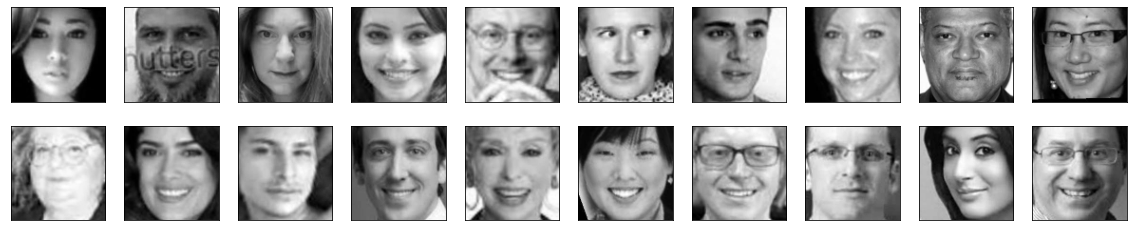

In [16]:
# before padding

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_train[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(x_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


#### 01a Pad the train data with -1 for left hand side

In [17]:
# variable: how much padding is good padding
# in this case the matrix is 200X200
# shall we take 10% of the size
# and pad that on all sides


In [18]:
perc=0.2
pad=int(perc*x_train[0].shape[1])
print("Number of rows on both sides = ",pad)
padding_val=0/255

denom=max(y_train)-min(y_train)
print(denom)



Number of rows on both sides =  20
1


In [19]:
def pad_multi(matrix,col_padding, row_padding,values):
    '''
    matrix shape: count X rows X columns X channels
    col_padding: (left_padding, right_padding)
    row_padding: (up_padding, below_padding)
    value: value to pad with
    '''
#     b=np.pad(a, ((1,1), (1,1), (0,0)), mode='constant',constant_values=(9))

    all_padded=[]
    for i in range(matrix.shape[0]):
        new_padded=np.pad(matrix[i],(col_padding,row_padding,(0,0)),'constant',constant_values=(values[i]))
#         this_padded.append(np.pad(matrix[i][0],padding_length,'constant',constant_values=(values[i])))
#         this_padded.append(np.pad(matrix[i][1],padding_length,'constant',constant_values=(values[i])))
#         this_padded.append(np.pad(matrix[i][2],padding_length,'constant',constant_values=(values[i])))        
        all_padded.append(new_padded)
    all_padded=np.array(all_padded)
    return all_padded
        
        

In [20]:
def pad_single_channel(matrix,col_padding,row_padding,values):
    all_padded=[]
    for i in range(matrix.shape[0]):
        new_mat=np.pad(matrix[i],(col_padding,row_padding),'constant',constant_values=(values[i]))
        all_padded.append(new_mat)
    all_padded=np.array(all_padded)
    return all_padded
        

In [21]:
values=[padding_val for i in range(x_train.shape[0])]
random.seed(12)
# values=[random.random() for i in range(x_train.shape[0])]
x_train_left=pad_single_channel(x_train,(pad,pad),(pad,pad),values)

rows=x_train_left.shape[1]
cols=x_train_left.shape[2]
print(rows,cols)

x_train_left=x_train_left.reshape(len(x_train_left),rows,cols,1)
print(x_train_left.shape)
# x_train_left = np.reshape(x_train_left, (len(x_train_left), 30, 30, 1))


140 140
(2828, 140, 140, 1)


In [22]:
print(x_train[0].shape,x_train_left[0].shape)

(100, 100) (140, 140, 1)


In [23]:
# x_train_left[10][0][20]

#### 01b Pad the train data with y_values for right hand side

In [24]:
(y_train[9])/denom 

0.0

In [25]:
val=[y_train[i]/denom for i in range(y_train.shape[0])]
x_train_right=pad_single_channel(x_train,(pad,pad),(pad,pad),val)

rows=x_train_right.shape[1]
cols=x_train_right.shape[2]
print(rows,cols)


x_train_right=x_train_right.reshape(len(x_train_right),rows,cols,1)

print(x_train_right.shape)

140 140
(2828, 140, 140, 1)


In [26]:
# x_train_right[10][0][20]

#### 01c Pad the test data with -1 for left hand side

In [27]:
values=[padding_val for i in range(x_test.shape[0])]
random.seed(12)
# values=[random.random() for i in range(x_train.shape[0])]

x_test_left=pad_single_channel(x_test,(pad,pad),(pad,pad),values)

rows=x_test_left.shape[1]
cols=x_test_left.shape[2]
print(rows,cols)


x_test_left=x_test_left.reshape(len(x_test_left),rows,cols,1)
print(x_test_left.shape)

140 140
(1394, 140, 140, 1)


#### 01d Pad the test data with y values for right hand side

In [28]:
x_test_right=[]

val=[y_test[i]/denom for i in range(y_test.shape[0])]


x_test_right=pad_single_channel(x_test,(pad,pad),(pad,pad),val)

rows=x_test_right.shape[1]
cols=x_test_right.shape[2]
print(rows,cols)

x_test_right=x_test_right.reshape(len(x_test_right),rows,cols,1)
print(x_test_right.shape)    

140 140
(1394, 140, 140, 1)


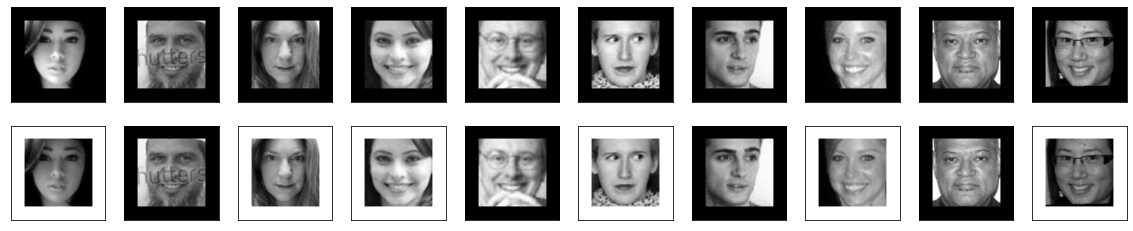

In [29]:
# after padding

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
#     print(x_train_right[i].shape)
    plt.imshow(x_train_left[i].reshape(rows,cols))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(x_train_right[i].reshape(rows,cols))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


### 02 Create and train the model

In [30]:
# x_train_right[2][0]

In [31]:
# input_img = keras.Input(shape=x_train_left[0].shape)

# x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
# x = layers.MaxPooling2D((2, 2), padding='same')(x)
# x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
# x = layers.MaxPooling2D((2, 2), padding='same')(x)
# x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
# encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# # at this point the representation is (4, 4, 8) i.e. 128-dimensional

# x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
# x = layers.UpSampling2D((2, 2))(x)
# x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
# x = layers.UpSampling2D((2, 2))(x)
# x = Cropping2D(cropping=((1, 1), (1, 1)), data_format=None)(x) # this is the added step
# x = layers.Conv2D(16, (3, 3), activation='relu',padding='same')(x)
# x = layers.UpSampling2D((2, 2))(x)

# decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# autoencoder = keras.Model(input_img, decoded)
# autoencoder.compile(optimizer='adam', loss='mse')

In [32]:
input_img = keras.Input(shape=x_train_left[0].shape)

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)


# at this point the representation is (4, 4, 8) i.e. 128-dimensional


x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
# x = Cropping2D(cropping=((1, 1), (1, 1)), data_format=None)(x) # this is the added step
x = layers.Conv2D(16, (3, 3), activation='relu',padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)

decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

In [33]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 140, 140, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 140, 140, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 70, 70, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 70, 70, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 35, 35, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 35, 35, 8)         584       
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 70, 70, 8)         0     

In [34]:
from keras.callbacks import TensorBoard

history=autoencoder.fit(x_train_left, x_train_right,
                epochs=200,
                batch_size=32,
                shuffle=True,
                validation_data=(x_test_left, x_test_right))


Epoch 1/200
89/89 [==============================] - 6s 28ms/step - loss: 0.1442 - val_loss: 0.1287
Epoch 2/200
89/89 [==============================] - 2s 20ms/step - loss: 0.1277 - val_loss: 0.1248
Epoch 3/200
89/89 [==============================] - 2s 20ms/step - loss: 0.1252 - val_loss: 0.1232
Epoch 4/200
89/89 [==============================] - 2s 20ms/step - loss: 0.1246 - val_loss: 0.1225
Epoch 5/200
89/89 [==============================] - 2s 20ms/step - loss: 0.1242 - val_loss: 0.1220
Epoch 6/200
89/89 [==============================] - 2s 20ms/step - loss: 0.1235 - val_loss: 0.1217
Epoch 7/200
89/89 [==============================] - 2s 20ms/step - loss: 0.1229 - val_loss: 0.1217
Epoch 8/200
89/89 [==============================] - 2s 20ms/step - loss: 0.1227 - val_loss: 0.1218
Epoch 9/200
89/89 [==============================] - 2s 21ms/step - loss: 0.1229 - val_loss: 0.1217
Epoch 10/200
89/89 [==============================] - 2s 20ms/step - loss: 0.1220 - val_loss: 0.1207

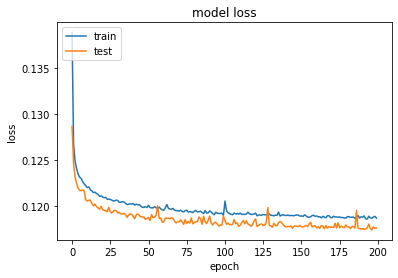

In [35]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'][:])
plt.plot(history.history['val_loss'][:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

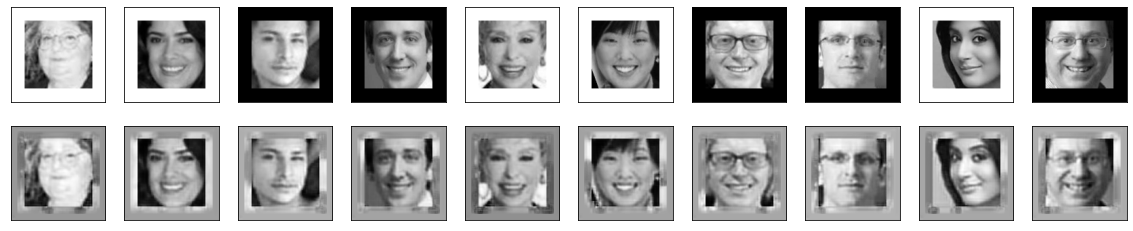

In [36]:
decoded_imgs = autoencoder.predict(x_test_left)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test_right[i].reshape(rows,cols))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(rows,cols))
    plt.gray()

    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [37]:
autoencoder.save("models/autoencoder_with_label.h")

INFO:tensorflow:Assets written to: models/autoencoder_with_label.h/assets


In [38]:
new_autoenc=load_model("models/autoencoder_with_label.h")

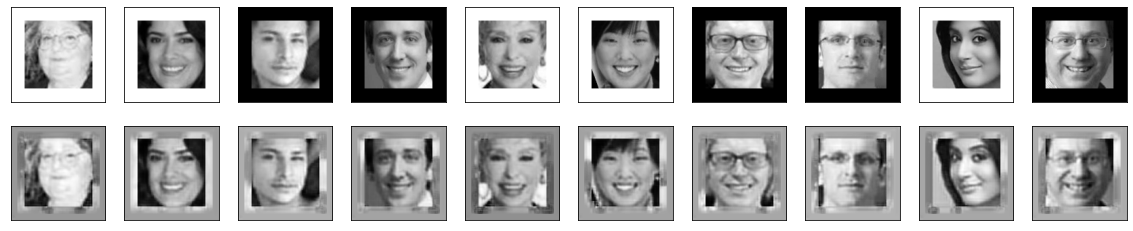

In [39]:
decoded_imgs = new_autoenc.predict(x_test_left)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test_right[i].reshape(rows, cols))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(rows, cols))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


### 03 Extract features and test with LogReg

In [40]:

encoder = Model(inputs=input_img, outputs=encoded)
# decoder=Model(inputs=encoded,outputs=decoded)
encoder.save('models/encoder_with_label.h5')
# decoder.save('models/decoder_with_label.h5')

In [41]:
def flatten_encoded_images_for_logreg(X_array):
    print(X_array.shape)
    X_array_flattened=[]
    for i in range(X_array.shape[0]):
        X_array_flattened.append(X_array[i].flatten())
    X_array_flattened=np.array(X_array_flattened)
    print("Shape is ",X_array_flattened.shape)
    return X_array_flattened

In [42]:
# load the model from file
encoder = load_model('models/encoder_with_label.h5')
# encode the train data
x_train_encode = encoder.predict(x_train_left)
x_train_encode_flat=flatten_encoded_images_for_logreg(x_train_encode)

# x_train_encode=x_train_encode.flatten()
print("Shape of encoded flat",x_train_encode_flat.shape)
# encode the test data
x_test_encode = encoder.predict(x_test_left)
x_test_encode_flat=flatten_encoded_images_for_logreg(x_test_encode)
print("Shape of encoded flat",x_test_encode_flat.shape)



(2828, 35, 35, 8)
Shape is  (2828, 9800)
Shape of encoded flat (2828, 9800)
(1394, 35, 35, 8)
Shape is  (1394, 9800)
Shape of encoded flat (1394, 9800)


In [43]:
# define the model
model = LogisticRegression()
# fit the model on the training set
model.fit(x_train_encode_flat, y_train)
# make predictions on the test set
yhat = model.predict(x_test_encode_flat)
# calculate classification accuracy
acc = accuracy_score(y_test, yhat)
print(acc)

0.9275466284074605


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### 04 Extract features and Test with a CNN

In [44]:
# https://towardsdatascience.com/building-a-convolutional-neural-network-cnn-in-keras-329fbbadc5f5

#### 04a Convert y values to categorical

In [45]:
#one-hot encode target column
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)
print(y_train_one_hot.shape,y_test_one_hot.shape)

(2828, 2) (1394, 2)


#### 04b Extract features using encoder

In [46]:
# load the model from file
encoder = load_model('models/encoder_with_label.h5')
# encode the train data
x_train_encode = encoder.predict(x_train_left)
print("Shape of training encoded images",x_train_encode.shape)

# encode the test data
x_test_encode = encoder.predict(x_test_left)
print("Shape of testing encoded images",x_test_encode.shape)


Shape of training encoded images (2828, 35, 35, 8)
Shape of testing encoded images (1394, 35, 35, 8)


In [47]:
print(x_train_encode[0].shape,x_test_encode[1].shape)

(35, 35, 8) (35, 35, 8)


### 04c create a CNN that takes encoded image as input

In [48]:
def get_model(x_train):
    # define a CNN to make the predictions
    #create model
    model = Sequential()#add model layers
    model.add(Conv2D(24, kernel_size=5, padding="same", activation='relu', input_shape=x_train[0].shape))
    model.add(MaxPool2D())
    model.add(Conv2D(48, kernel_size=5, padding="same", activation='relu'))
    model.add(MaxPool2D())
    model.add(Conv2D(64, kernel_size=5, padding="same", activation='relu'))
    model.add(MaxPool2D(padding='same'))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(2, activation='softmax'))

    #compile model using accuracy to measure model performance
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])    
    return model
    

In [49]:
acc_list=[]
for i in range(20):
    model=get_model(x_train_encode)
    # print(model.summary())
    #train the model
    num_epochs=40
    history=model.fit(x_train_encode, y_train_one_hot, validation_data=(x_test_encode, y_test_one_hot), epochs=num_epochs,verbose=0)
    loss,acc=model.evaluate(x_test_encode, y_test_one_hot)
    print("Accuracy is ",acc)
    acc_list.append(acc)


44/44 [==============================] - 0s 3ms/step - loss: 0.3214 - accuracy: 0.9254
Accuracy is  0.9253945350646973
44/44 [==============================] - 0s 3ms/step - loss: 0.3947 - accuracy: 0.9326
Accuracy is  0.9325681328773499
44/44 [==============================] - 0s 3ms/step - loss: 0.4137 - accuracy: 0.9333
Accuracy is  0.9332855343818665
44/44 [==============================] - 0s 3ms/step - loss: 0.6270 - accuracy: 0.8702
Accuracy is  0.8701578378677368
44/44 [==============================] - 0s 3ms/step - loss: 0.3637 - accuracy: 0.9154
Accuracy is  0.9153515100479126
44/44 [==============================] - 0s 3ms/step - loss: 0.3681 - accuracy: 0.9240
Accuracy is  0.9239598512649536
44/44 [==============================] - 0s 3ms/step - loss: 0.5264 - accuracy: 0.8938
Accuracy is  0.8938307166099548
44/44 [==============================] - 0s 3ms/step - loss: 0.4468 - accuracy: 0.9319
Accuracy is  0.931850790977478
44/44 [==============================] - 0s 3ms/s

In [50]:
print(sum(acc_list)/len(acc_list))


0.9229913979768753


In [51]:
# 0.8397417604923249


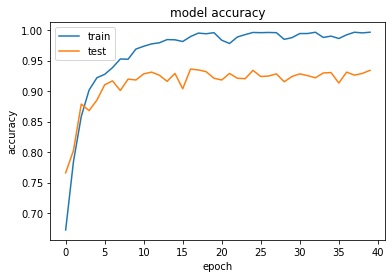

In [52]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()